In [71]:
import numpy as np
from collections import namedtuple
from tqdm import tnrange, tqdm_notebook

LATTICE_SIZE = 10
N_CONFIGS_PER_SAMPLE = 10
N_STEPS_STABILIZE = 10000
N_STEPS_AVG = 1000

def create_random_config(N):
    """Create spin configuration of NxN lattice"""
    return 2 * np.random.randint(2, size=(N, N)) - 1

# better way:
# https://tanyaschlusser.github.io/posts/mcmc-and-the-ising-model/
def get_dH(lattice, location):
    """ H = - Sum_<ij>(s_i s_j) """
    i, j = location
    N, _ = lattice.shape
    H, Hflip = 0, 0
    for di, dj in ((-1, 0), (1, 0), (0, -1), (0, 1)):
        ii = (i + di) % N
        jj = (j + dj) % N
        H -= lattice[ii, jj] * lattice[i, j]
        Hflip += lattice[ii, jj] * lattice[i, j]
    return Hflip - H

def neighbours_sum(lattice, loc):
    i, j = loc
    N, _ = lattice.shape
    up = (i, (j-1)%N)
    left = ((i-1)%N, j)
    right = ((i+1)%N, j)
    down = (i, (j+1)%N)
    return lattice[up] + lattice[down] + lattice[left] + lattice[right]

def step(lattice, T):
    # Pick a random position in a lattice
    (N, _) = lattice.shape
    indices = np.random.randint(0, high=N, size=2)
    i, j = indices[0], indices[1]
    
    dH = get_dH(lattice, (i, j))
    
    maybe_flip(lattice, dH, (i, j), T)
    return lattice

def maybe_flip(lattice, dH, loc, T):
    i, j = loc
    
    if dH < 0:
        lattice[i,j] = -lattice[i,j]
    elif np.random.rand() < np.exp(-dH / T):
            lattice[i, j] = -lattice[i,j]
    return lattice

def energy(config):
    energy = 0
    for i in range(len(config)):
        for j in range(len(config)):
            entry = config[i,j]
            nb = neighbours_sum(config, (i, j))
            energy += -nb*entry
    return energy/4.


def mag(config):
    '''Magnetization of a given configuration'''
    mag = np.sum(config)
    return mag



In [73]:
Sample = namedtuple('Sample', ['energy_avg', 'energy_std', 'mag_avg', 'mag_std'])

def stabilize(config, T):
    for _ in range(N_STEPS_STABILIZE):
        step(config, T)    

def sample(T):
    """Obtain a single sample point for a given temperature"""
    energies = []
    mags = []

    for _ in tqdm_notebook(range(N_CONFIGS_PER_SAMPLE), leave=False):
        
        config = create_random_config(N=LATTICE_SIZE)
        
        stabilize(config, T)
        
        for _ in tqdm_notebook(range(N_STEPS_AVG), leave=False):
            step(config, T)
            energies.append(energy(config))
            mags.append(mag(config))

    return Sample(energy_avg=np.mean(energies), energy_std=np.std(energies),
                  mag_std=np.std(mags), mag_avg=np.mean(mags))

In [74]:
temps = np.linspace(0.1, 4.0, num=15)

samples = []
for t in tqdm_notebook(temps):
    samples.append(sample(t))
    
energy_avgs = [s.energy_avg for s in samples]
energy_stds   = [s.energy_std  for s in samples]
mag_avgs    = [s.mag_avg    for s in samples]
mag_stds      = [s.mag_std     for s in samples]

# Write data to disk

In [75]:
import pandas as pd
import os
fname = 'data.df'

data = {'Energy Mean':energy_avgs, 'Energy Std' : energy_stds, 'Mag Mean' : mag_avgs, 'Mag Std' : mag_stds} 
data = pd.DataFrame(data)
data.to_pickle(fname)  # where to save it, usually as a .pkl

# Read data from disk

In [105]:
import pandas as pd
import os
fname = 'data.df'
data = pd.read_pickle(fname)
print(data)
# Convert for better shape for plotting
long_data = data.reset_index().melt('index', var_name='Metric', value_name='Value')
print(long_data)

    Energy Mean  Energy Std  Mag Mean    Mag Std
0     -100.0000    0.000000  -60.0000  80.000000
1      -96.0000    8.000000    0.0000  89.442719
2      -97.9864    6.042898    7.9864  94.745916
3      -99.8572    0.742165   40.0326  91.560110
4      -99.5428    1.457315  -39.8962  91.445236
5      -98.2248    2.544143   -0.0618  99.071916
6      -90.1962    8.161440   53.9478  75.634411
7      -86.6334    8.380311  -19.9084  87.962231
8      -69.3908   12.722927    1.0464  73.865804
9      -60.7018   11.711562    7.0392  63.866574
10     -43.4748   11.947090  -12.2100  38.089378
11     -37.3960   10.040278   -1.4912  30.174882
12     -32.2676    8.630758   -4.0874  20.605493
13     -30.0174    7.738637   -0.6810  18.144703
14     -25.8894    7.651259    0.0092  18.146601
    index       Metric       Value
0       0  Energy Mean -100.000000
1       1  Energy Mean  -96.000000
2       2  Energy Mean  -97.986400
3       3  Energy Mean  -99.857200
4       4  Energy Mean  -99.542800
5     

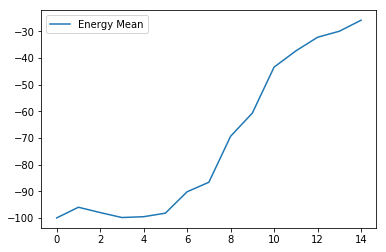

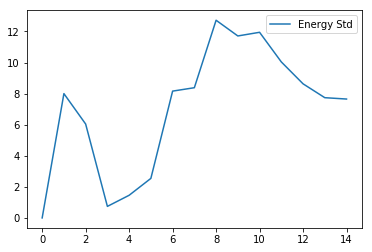

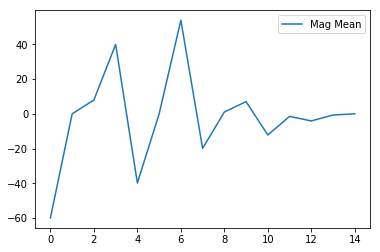

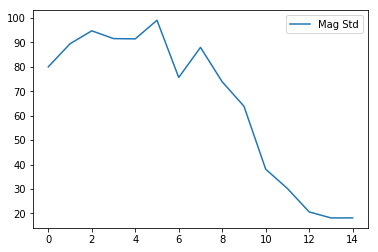

In [111]:
%matplotlib inline
import matplotlib.pyplot as plt

data.plot(y='Energy Mean')
plt.show()
data.plot(y='Energy Std')
plt.show()
data.plot(y='Mag Mean')
plt.show()
data.plot(y='Mag Std')
plt.show()


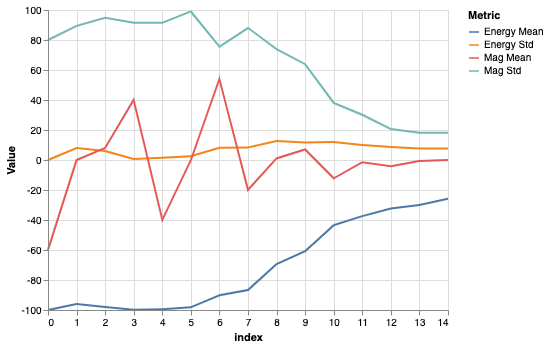

In [104]:
import altair as alt
alt.renderers.enable('notebook')
alt.Chart(long_data).mark_line().encode(y='Value', x='index', color='Metric')